In [1]:
# imports
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from datetime import datetime
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Load all the datasets and extract the climate quotes for each year into a separate pickle file

In [ ]:
# RUN ONLY ONCE
# iteratively extract climate quotation datasets for each year

for year in range(2015, 2021):
    print(year)
    df_reader = pd.read_json('data/quotebank/quotes-{}.json.bz2'.format(year), lines=True, compression='bz2', chunksize=10000)

    climate_quotes = []
    for chunk in df_reader:
        df = chunk[chunk.quotation.str.contains('climate', case=False, na=False)]
        climate_quotes.append(df)
    print('Chunks for year {} done'.format(year))
    climate_df = pd.concat(climate_quotes)
    # pickle pickle pickle
    climate_df.to_pickle('data/climate_df_{}.pkl'.format(year))
    print('Pickle done')

2015
Chunks for year 2015 done
Pickle done
2016
Chunks for year 2016 done
Pickle done
2017


**Loading the climate dataframes pickles for each year into a dictionary**

In [2]:
climate_dfs = {}
for i in range(2015, 2021):
    climate_dfs[i] = pd.read_pickle('data/climate_df_{}.pkl'.format(i))

In [3]:
# full climate df
full_climate_df = pd.DataFrame(columns = climate_dfs[2015].columns)
for y in range(2015, 2021):
    full_climate_df = full_climate_df.append(climate_dfs[y])

### Wiki data

In [4]:
# load wiki data
#wiki_data = pd.read_parquet('parquet-data/speaker_attributes.parquet')

# load the labels for wiki data
wiki_labels = pd.read_csv('data/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

In [5]:
wiki_labels

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America
...,...,...
Q106302506,didgeridooist,musician who plays the didgeridoo
Q106341153,biochemistry teacher,teacher of biochemistry at any level
Q106368830,2018 Wigan Metropolitan Borough Council electi...,NaN


**Cleaning dataset**

In [6]:
# RESOLVES THE TRUMP PROBLEM
def clean_name(df, name):
    """Set a unique label_name for speakers with several versions of name"""
    
    df_copy = df.copy()
    
    df_name = df[df['speaker'].apply(lambda x: name in x)]
    # get the qid of the speaker in wiki_data
    wiki_qid = df_name['qids'].iloc[0][0]
    # get the label of speaker
    label_name = wiki_data[wiki_data['id'] == wiki_qid]['label'].iloc[0].lower()
    #replace speaker with his label
    df_copy = df.replace(df_name['speaker'].iloc[0], label_name)
    
    return df_copy

In [7]:
def replace_name(q, qids_to_name={}):
    if 0 < len(q.qids):
        if q.qids[0] not in qids_to_name:
            qids_to_name[q.qids[0]] = q.speaker
        else:
            q.speaker = qids_to_name[q.qids[0]]
    return q

In [8]:
def clean_df(df):
    """Cleans the dataset for speakers only for now"""
    
    # remove all the 'None' speakers
    df = df[df['speaker'] != 'None']
    
    df = df.apply(replace_name, axis=1)
    # all names to lower case
    #df['speaker'] = df['speaker'].str.lower()
    
    #clean different Trump names
   # trump_names = df[df['speaker'].apply(lambda x: ('trump' in x) and ('president' in x) or x=='donald trump' or x=='donald j. trump')]['speaker'].unique()
    #for t in trump_names:
     #   df = clean_name(df, t)
        
    # clean different Obama names
    #obama_names = df[df['speaker'].apply(lambda x: ('barack' in x) or ('president' in x and 'obama' in x))]['speaker'].unique()
    #for i in obama_names:
     #   df = clean_name(df, i)
    
    
    return df

In [9]:
full_climate_df = clean_df(full_climate_df)

In [10]:
full_climate_df.qids.apply(lambda x: x[0]).unique().shape

(46792,)

In [87]:
wiki_speakers = pd.DataFrame(columns=wiki_data.columns)
speakers_ids = full_climate_df.qids.apply(lambda x: x[0]).unique().tolist()

wiki_data = wiki_data.set_index(wiki_data.id)


NameError: name 'wiki_data' is not defined

In [52]:
# DO ONCE
%%time
from tqdm import tqdm

for i in tqdm(speakers_ids):
    if i in wiki_data.index:
        wiki_speakers = wiki_speakers.append(wiki_data.loc[i])

100%|██████████| 46792/46792 [09:12<00:00, 84.76it/s] 

CPU times: user 9min 11s, sys: 2.05 s, total: 9min 13s
Wall time: 9min 12s


In [53]:
#DO ONCE
# pickle pickle pickle
wiki_speakers.to_pickle('data/wiki_speakers.pkl')

Load the wiki speakers pickle

In [9]:
wiki_speakers = pd.read_pickle('data/wiki_speakers.pkl')

In [24]:
wiki_speakers

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
Q23762578,None,[+1947-12-20T00:00:00Z],"[Q902, Q843]",[Q6581097],1319692653,None,None,[Q82955],[Q1361491],None,Q23762578,Anisul Islam Mahmud,None,item,[Q432]
Q18199405,None,[+1963-08-13T00:00:00Z],[Q34],[Q6581097],1280534852,None,None,[Q1281618],None,None,Q18199405,Anders Jansson,None,item,None
Q5415483,None,[+1981-11-01T00:00:00Z],[Q30],[Q6581097],1378227353,None,None,"[Q19204627, Q15295720]",None,None,Q5415483,Evan Mathis,None,item,None
Q4911497,"[Warren Wilhelm, Jr., Bill deBlasio, Warren Wi...",[+1961-05-08T00:00:00Z],[Q30],[Q6581097],1393528151,None,None,"[Q82955, Q40348]",[Q29552],None,Q4911497,Bill de Blasio,None,item,None
Q3061333,[Evan Lee Scribner],[+1985-07-19T00:00:00Z],[Q30],[Q6581097],1377322587,None,None,[Q10871364],None,None,Q3061333,Evan Scribner,None,item,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q19271892,None,[+1959-00-00T00:00:00Z],[Q145],[Q6581097],1392939803,None,None,[Q43845],None,None,Q19271892,Chris Banks,None,item,None
Q15815037,None,[+1964-09-08T00:00:00Z],"[Q225, Q36704]",[Q6581072],1375826663,None,None,[Q1476215],None,None,Q15815037,Dunja Mijatović,None,item,None
Q43911177,None,None,None,[Q6581097],985959416,None,None,[Q5131856],None,None,Q43911177,James Meldrum,None,item,None
Q5087105,None,[+1954-11-22T00:00:00Z],[Q30],[Q6581097],1315183141,None,None,"[Q43845, Q3282637]",None,None,Q5087105,Chase Carey,None,item,None


In [25]:
wiki_speakers = wiki_speakers.drop_duplicates('id')


We will focus on climate datasets 2018 and 2019

In [26]:
# cleaning
climate_dfs[2018] = clean_df(climate_dfs[2018])
climate_dfs[2019] = clean_df(climate_dfs[2019])

**Top 10 functions**

In [27]:
def top_speakers(df):
    """function to extract the top 10 speakers"""
    
    top_speakers = df.groupby('speaker')['speaker'].count().sort_values(ascending=False).to_frame().add_suffix('_count')
    top_speakers.reset_index(drop=False, inplace=True)
    
    return top_speakers.head(10)


def top_quotations(df):
    """function to extract the top 10 msot repeated quotations"""
    
    top_quotations = df.sort_values('numOccurrences', ascending=False)[['speaker', 'quotation', 'numOccurrences']]
    # remove quotations of unidentified speakers
    top_quotations.reset_index(drop=True, inplace=True)
    
    return top_quotations.head(10)

In [28]:
# quick visualization
def visualize_top(x, y):
    plt.figure(figsize=(16, 6))
    sns.barplot(x=x,y=y)
    plt.title("Most quoted speakers")
    

**Top speakers barplots**

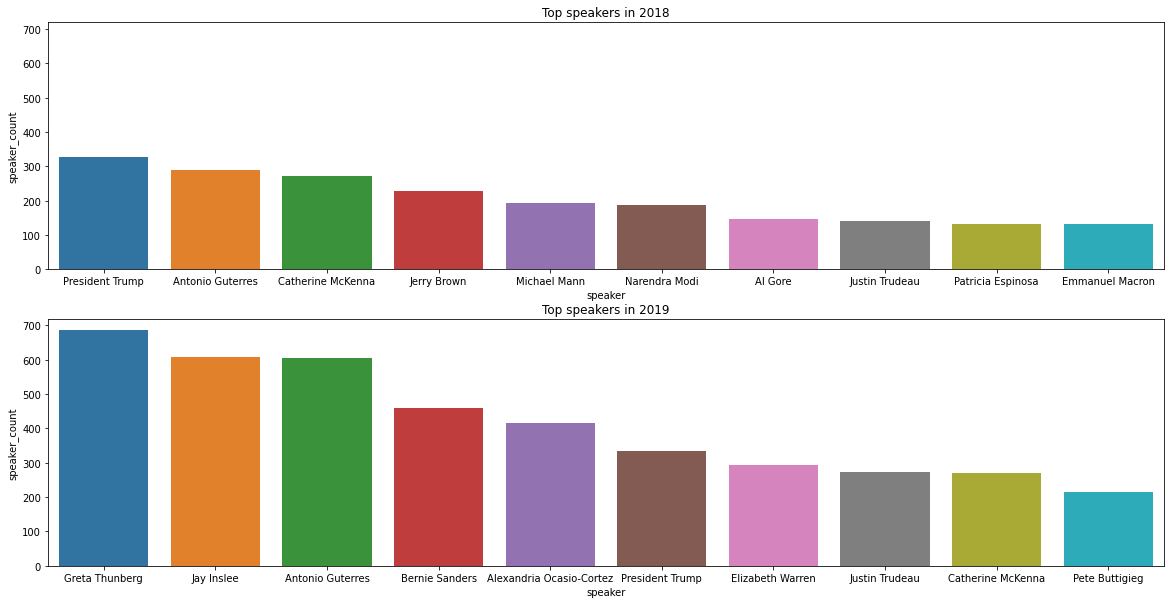

In [29]:
fig, ax = plt.subplots(2, figsize=(20,10), sharey=True)

# show top speakers from 2018 and 2019
speakers_2018 = top_speakers(climate_dfs[2018])
speakers_2019 = top_speakers(climate_dfs[2019])

ax[0].set_title('Top speakers in 2018')
ax[1].set_title('Top speakers in 2019')

sns.barplot(ax = ax[0], x=speakers_2018.speaker, y=speakers_2018.speaker_count)
sns.barplot(ax = ax[1], x=speakers_2019.speaker, y=speakers_2019.speaker_count)

plt.show()

In [30]:
# show top quotations from 2018
top_quotations(climate_dfs[2018])

,speaker,quotation,numOccurrences
0,Valeri Liukin,"the present climate causes me, and more import...",578
1,Greta Thunberg,School strike for the Climate.,425
2,Greta Thunberg,"School Strike For Climate,",302
3,Antonio Guterres,Even as we witness devastating climate impacts...,296
4,Jim Steele,What's happened with the more warming climate ...,288
5,President Trump,"There is a cooling, and there's a heating. I m...",287
6,President Trump,"I'm not denying climate change,",285
7,Kim Jong Un,"warm climate of reconciliation and dialogue,",283
8,Dave Robertson,I would say that the obvious inability in the ...,278
9,Katharine Hayhoe,"As a climate scientist, it is almost surreal.",256


In [31]:
# show top quotations from 2019
top_quotations(climate_dfs[2019])

,speaker,quotation,numOccurrences
0,Gavin Newsom,You don't believe in climate change. You are e...,474
1,President Trump,"You're bang out of order, you're wrong... you ...",463
2,Nancy Pelosi,We must ensure a climate of integrity and dign...,407
3,President Trump,"I did mention a number of things, I did say th...",405
4,Mark Carney,climate action and climate finance,384
5,Ben de Pear,"However, as we made clear to him repeatedly, b...",362
6,Helge Braun,We all share an interest in climate protection...,350
7,Scott Morrison,"climate change, along with many other factors.",334
8,Leo Varadkar,do more on climate action,326
9,Stefan Rahmstorf,monthly heat records all over the globe occur ...,280


In [32]:
# for top newspapers talking about climate
from tld import get_tld

def get_domain(url):
    res = get_tld(url, as_object=True)
    return res.domain

# function extracting the top 10 newspapers mentioning climate 
def top_newspapers(df):
    top_newspapers = pd.Series([x for _list in df['urls'] for x in _list]).apply(lambda u: get_domain(u)).value_counts()
    top_newspapers = top_newspapers.to_frame().reset_index(drop=False)
    top_newspapers.columns = ['newspaper', 'count']
    
    return top_newspapers.head(10)


### Metrics of top speakers

**Gender**

In [67]:
speakers_2018

,speaker,speaker_count,gender,age,political_party
0,President Trump,328,male,75,Republican Party
1,Antonio Guterres,289,male,72,Socialist Party
2,Catherine McKenna,273,female,50,Liberal Party of Canada
3,Jerry Brown,228,male,83,Democratic Party
4,Michael Mann,193,male,79,None
5,Narendra Modi,186,male,71,Bharatiya Janata Party
6,Al Gore,146,male,73,Democratic Party
7,Justin Trudeau,140,male,50,Liberal Party of Canada
8,Patricia Espinosa,133,female,63,National Action Party
9,Emmanuel Macron,132,male,44,La République En Marche


In [50]:
# get the list of qids for a speaker from df
def get_qids(df, name):
    qids = df[df.speaker == name].iloc[0].qids
    
    return qids

# get the gender of the speaker
# ids: the list of qids of the speaker 
def get_gender(ids):
    
    if not ids:
        gender = None
    else:
        qid = wiki_speakers.loc[ids[0]]['gender'][0]
        
        gender = wiki_labels.loc[qid]['Label']
    
    return gender


Lets see the proportion of men and women in top 10 speakers

In [51]:
# add the gender column for top speakers
speakers_2018['gender'] = speakers_2018['speaker'].apply(lambda s: get_qids(climate_dfs[2018],s)).apply(lambda q: get_gender(q))
speakers_2019['gender'] = speakers_2019['speaker'].apply(lambda s: get_qids(climate_dfs[2019],s)).apply(lambda q: get_gender(q))

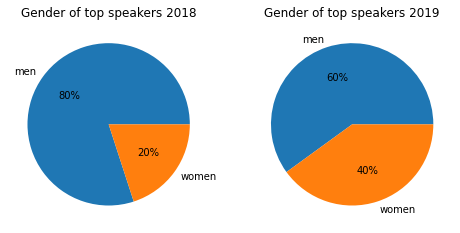

In [52]:
# counts 2018
nb_men_2018 = speakers_2018[speakers_2018.gender == 'male'].speaker.count()
nb_women_2018 = 10 - nb_men_2018
# counts 2019
nb_men_2019 = speakers_2019[speakers_2019.gender == 'male'].speaker.count()
nb_women_2019 = 10 - nb_men_2019

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,6))

ax1.set_title('Gender of top speakers 2018')
ax2.set_title('Gender of top speakers 2019')

ax1.pie([nb_men_2018, nb_women_2018], labels=['men', 'women'], autopct='%1.0f%%')
ax2.pie([nb_men_2019, nb_women_2019], labels=['men', 'women'], autopct='%1.0f%%')

plt.show()

**Age**

In [36]:
# get the age of the speaker
def get_age(ids):
    
    if not ids:
        age = Nan
    else:
        birth_date = wiki_speakers.loc[ids[0]]['date_of_birth'][0]
        birth_year = birth_date[1:5]
        age = int(datetime.now().strftime('%Y')) - int(birth_year)
        
    return age
    

In [37]:
# add the gender column for top speakers
speakers_2018['age'] = speakers_2018['speaker'].apply(lambda s: get_qids(climate_dfs[2018],s)).apply(lambda q: get_age(q))
speakers_2019['age'] = speakers_2019['speaker'].apply(lambda s: get_qids(climate_dfs[2019],s)).apply(lambda q: get_age(q))

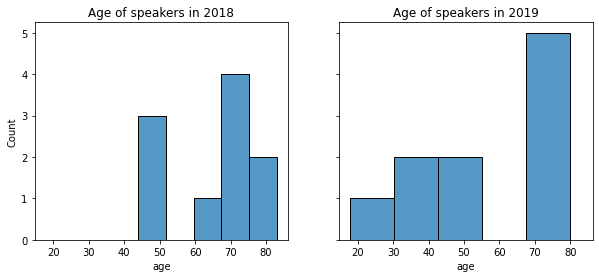

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

ax1.set_title('Age of speakers in 2018')
ax2.set_title('Age of speakers in 2019')

sns.histplot(speakers_2018['age'], ax = ax1)
sns.histplot(speakers_2019['age'], ax = ax2)

plt.show()


**Political party**

In [39]:
# get the political party of the speaker
def get_party(ids):
    if not ids:
        party = None
    else:
        party_id = wiki_speakers.loc[ids[0]].party
        
        if party_id is None:
            party = None
        else:
            party = wiki_labels.loc[party_id[0]].Label
        
    return party

In [40]:
speakers_2018['political_party'] = speakers_2018['speaker'].apply(lambda s: get_qids(climate_dfs[2018],s)).apply(lambda q: get_party(q))
speakers_2019['political_party'] = speakers_2019['speaker'].apply(lambda s: get_qids(climate_dfs[2019],s)).apply(lambda q: get_party(q))

In [41]:
party_count_2018 = speakers_2018.groupby('political_party').speaker.count().to_frame()
party_count_2019 = speakers_2019.groupby('political_party').speaker.count().to_frame()

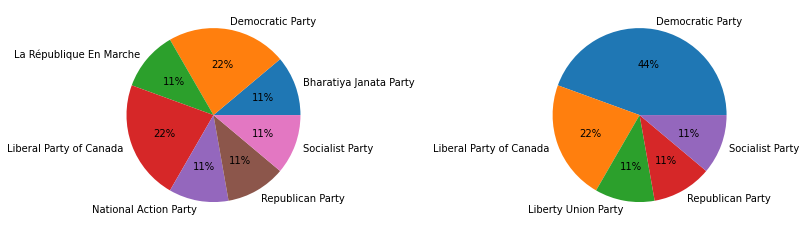

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))

ax1.pie(party_count_2018.speaker.tolist(), labels = party_count_2018.index.tolist(), autopct='%1.0f%%')
ax2.pie(party_count_2019.speaker.tolist(), labels = party_count_2019.index.tolist(), autopct='%1.0f%%')

plt.show()